### Deepdream

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
import time

### Image Processing helper function

In [3]:
def load_image(image_path,max_dim=None):
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

### Calculate Loss

In [4]:
def calc_loss(img, model):

    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

### Load Image

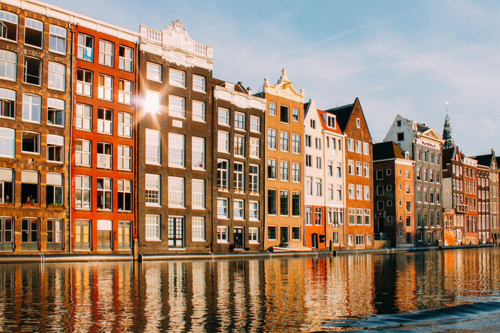

In [5]:
original_img = load_image('../../data/test_images/architecture_4.png', max_dim=500)
show(original_img)

## Download, save and read model
Download and prepare a pre-trained image classification model. You will use InceptionV3 which is similar to the model originally used in DeepDream. <br>
Note that any pre-trained model will work, although you will have to adjust the layer names below if you change this. 

In [7]:
base_model = tf.keras.models.load_model('../../models/inception_v3/')

### Deep Dreaming Intuition
The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.The InceptionV3 architecture is quite large  For DeepDream, the layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper. <br>

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves. To avoid this issue you can split the image into tiles and compute the gradient for each tile. Applying random shifts to the image before each tiled computation prevents tile seams from appearing. Start by implementing the random shift:

### Load the model

In [8]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### Add a random roll

In [12]:
def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0,1])
    return shift, img_rolled

### Random roll the image along x and y axis

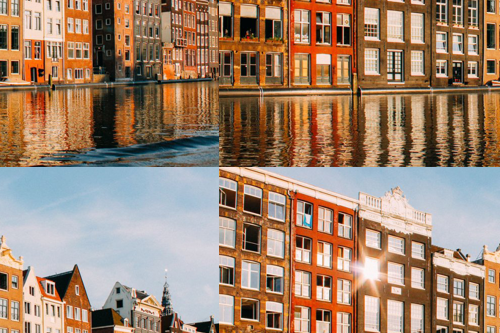

In [14]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

### Tiled Deep Dreamer

In [15]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[2], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.int32),))
    
    def __call__(self, img, img_size, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)

        #Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        xs = tf.range(0, img_size[1], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_size[0], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)
                    img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
                    loss = calc_loss(img_tile, self.model)

                gradients = gradients + tape.gradient(loss, img_rolled)

        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        return gradients 

### Algorithm with Octaves

In [16]:
def run_deep_dream_with_octaves(img, steps_per_octave=50, step_size=0.02, 
                                octaves=range(-1,2), octave_scale=1.3):
    
    base_shape = tf.shape(img)
    img = tf.keras.utils.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        new_size = tf.cast(new_size, tf.int32)
        img = tf.image.resize(img, new_size)

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img, new_size)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
            
            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))
    
    result = deprocess(img)
    return result

### Run Deep Dream

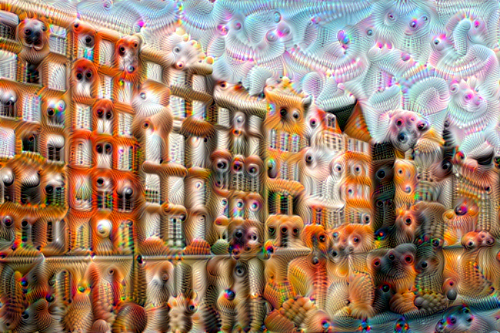

In [17]:
starttime = time.time()
base_shape = tf.shape(img_rolled)[:-1]
get_tiled_gradients = TiledGradients(dream_model)
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
endtime = time.time()
endtime-starttime
starttime = time.time()